<a href="https://colab.research.google.com/github/pankajagrawal925/Text_Clustering/blob/master/Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textsearch
!pip install contractions
import nltk
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 245kB 8.5MB/s 
     |████████████████████████████████| 317kB 38.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81708 sha256=fd3c5a509b96d03cc0d6520b760aeefc53ccfbdfc8a141f40528148e9f23dcda
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load and View Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/tmdb_5000_movies (1).csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [5]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [6]:
df = df[['title', 'tagline', 'overview', 'popularity']]
df.tagline.fillna('', inplace=True)
df['description'] = df['tagline'].map(str) + ' ' + df['overview']
df.dropna(inplace=True)
df = df.sort_values(by=['popularity'], ascending=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 546 to 4553
Data columns (total 5 columns):
title          4800 non-null object
tagline        4800 non-null object
overview       4800 non-null object
popularity     4800 non-null float64
description    4800 non-null object
dtypes: float64(1), object(4)
memory usage: 225.0+ KB


In [7]:
df.head()

,title,tagline,overview,popularity,description
546,Minions,"Before Gru, they had a history of bad bosses","Minions Stuart, Kevin and Bob are recruited by...",875.581305,"Before Gru, they had a history of bad bosses M..."
95,Interstellar,Mankind was born on Earth. It was never meant ...,Interstellar chronicles the adventures of a gr...,724.247784,Mankind was born on Earth. It was never meant ...
788,Deadpool,Witness the beginning of a happy ending,Deadpool tells the origin story of former Spec...,514.569956,Witness the beginning of a happy ending Deadpo...
94,Guardians of the Galaxy,All heroes start somewhere.,"Light years from Earth, 26 years after being a...",481.098624,All heroes start somewhere. Light years from E...
127,Mad Max: Fury Road,What a Lovely Day.,An apocalyptic story set in the furthest reach...,434.278564,What a Lovely Day. An apocalyptic story set in...


# Cluster Similar Movies

In [8]:
#Text Pre-Processing
import nltk
import re
import numpy as np
import contractions

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)


4800

# Extract TF-IDF Features

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stop_words + ['one', 'two', 'three', 'four', 'five', 'get']
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(4800, 6100)

# Cluster Movies Using K-Means

K-Means finds the best centroids by alternating between

(1) assigning data points to clusters based on the current centroids (2) chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.

till convergence..

**Features we are using here is BOW based feature**

In [10]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(cv_matrix)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [11]:
from collections import Counter
Counter(km.labels_)

Counter({0: 588, 1: 18, 2: 2769, 3: 449, 4: 417, 5: 559})

In [0]:
df['kmeans_cluster'] = km.labels_

In [0]:
movie_clusters = (df[['title','kmeans_cluster','popularity']].sort_values(by=['kmeans_cluster','popularity'],ascending=False).groupby('kmeans_cluster').head(20))

In [14]:
movie_clusters


,title,kmeans_cluster,popularity
108,Terminator Genisys,5,202.042635
9,Batman v Superman: Dawn of Justice,5,155.790452
662,Fight Club,5,146.757391
238,Teenage Mutant Ninja Turtles,5,143.350376
362,Pixels,5,140.849495
...,...,...,...
694,The Bourne Identity,0,86.476817
2313,The Mask,0,85.303180
566,Cars,0,82.643036
287,Django Unchained,0,82.121691


In [0]:
movie_clusters = movie_clusters.copy(deep=True)

In [16]:
for cluster_num in range(NUM_CLUSTERS):
  movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
  print('CLUSTER #'+str(cluster_num+1))
  print('Popular Movies:', movies)
  print('-'*80)


CLUSTER #1
Popular Movies: ['Mad Max: Fury Road', 'Inception', 'The Godfather', "Pirates of the Caribbean: At World's End", 'The Shawshank Redemption', 'Harry Potter and the Chamber of Secrets', 'Inside Out', "Harry Potter and the Philosopher's Stone", 'The Hobbit: An Unexpected Journey', 'Fifty Shades of Grey', 'Blade Runner', 'Psycho', 'Up', 'The Lion King', 'Taken 3', 'The Bourne Identity', 'The Mask', 'Cars', 'Django Unchained', 'World War Z']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Movies: ['Harry Potter and the Prisoner of Azkaban', 'Saw', 'The Incredible Hulk', 'Now You See Me 2', 'Pocahontas', 'Goldfinger', 'Jack the Giant Slayer', 'Back to the Future Part II', 'DragonHeart', 'Dead Snow', 'The Hole', 'The Calling', 'Of Gods and Men', 'Firestorm', 'Stranded', '2:13', 'Henry & Me', 'The Rocket: The Legend of Rocket Richard']
--------------------------------------------------------------------------------
CLUSTER #3
Popul

#Clustering with Embeddings
Here we use FastText embeddings as features and use K-means for clustering

In [0]:
from gensim.models import FastText

tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, size=300, window=40, min_count=2, workers=4, sg=1, iter=100)

In [0]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [19]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 300)
doc_vecs_ft.shape

(4800, 300)

In [0]:
NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(doc_vecs_ft)

In [21]:
Counter(km.labels_)

Counter({0: 557, 1: 617, 2: 920, 3: 528, 4: 1358, 5: 820})

In [0]:
df['kmeans_cluster'] = km.labels_
movie_clusters = (df[['title', 'kmeans_cluster', 'popularity']]
                  .sort_values(by=['kmeans_cluster', 'popularity'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(30))
movie_clusters = movie_clusters.copy(deep=True)

In [23]:
for cluster_num in range(NUM_CLUSTERS):
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #1
Popular Movies: ['Interstellar', 'Deadpool', 'Guardians of the Galaxy', 'Mad Max: Fury Road', 'Jurassic World', 'Dawn of the Planet of the Apes', 'The Martian', 'Avatar', 'The Avengers', 'Teenage Mutant Ninja Turtles', 'X-Men: Apocalypse', 'Rise of the Planet of the Apes', 'Avengers: Age of Ultron', 'Harry Potter and the Chamber of Secrets', 'Tomorrowland', 'Transformers: Age of Extinction', 'Spider-Man 3', 'Lucy', 'Gravity', 'The Fifth Element', 'Men in Black', 'San Andreas', 'Ice Age', 'Ex Machina', 'Alien', 'Blade Runner', 'Men in Black II', 'The Adventures of Tintin', '2001: A Space Odyssey', 'Jupiter Ascending']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Movies: ['Pulp Fiction', 'The Godfather: Part II', 'Titanic', 'Black Swan', 'Nightcrawler', 'Cloud Atlas', 'GoodFellas', 'Straight Outta Compton', 'The Great Gatsby', 'The Theory of Everything', 'Mary Poppins', 'Dallas Buyers Club', 'The Big Short', 'Moulin Rouge!

#**Hierarchical Clustering**

We will be using a agglomerative clustering algorithm, which is hierarchical clustering using a bottom up approach i.e. each observation or document starts in its own cluster and clusters are successively merged together using a distance metric which measures distances between data points and a linkage merge criterion.

We choose the Ward’s minimum variance method as our linkage criterion to minimize total within-cluster variance. Hence, at each step, we find the pair of clusters that leads to minimum increase in total within-cluster variance after merging.

In [0]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

**Calculate Linkage Matrix using Cosine Similarity**

In [0]:
def ward_hierarchical_clustering(feature_matrix):
  cosine_distance = 1 - cosine_similarity(feature_matrix)
  linkage_matrix = ward(cosine_distance)
  return linkage_matrix


Plot Hierarichal Structure as Dendogram

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hierarchical_clusters(linkage_matrix, movie_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=movie_titles,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: movie_titles[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('movie_hierachical_clusters.png', dpi=200)

In [0]:
linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

In [28]:
np.set_printoptions(suppress=True)
print(linkage_matrix)

[[1680.         3007.            1.33021673    2.        ]
 [ 817.         2263.            1.42917788    2.        ]
 [1796.         2898.            1.47008508    2.        ]
 ...
 [4764.         9595.           45.34696421 1595.        ]
 [9587.         9594.           52.41620773 3205.        ]
 [9596.         9597.           87.92984326 4800.        ]]


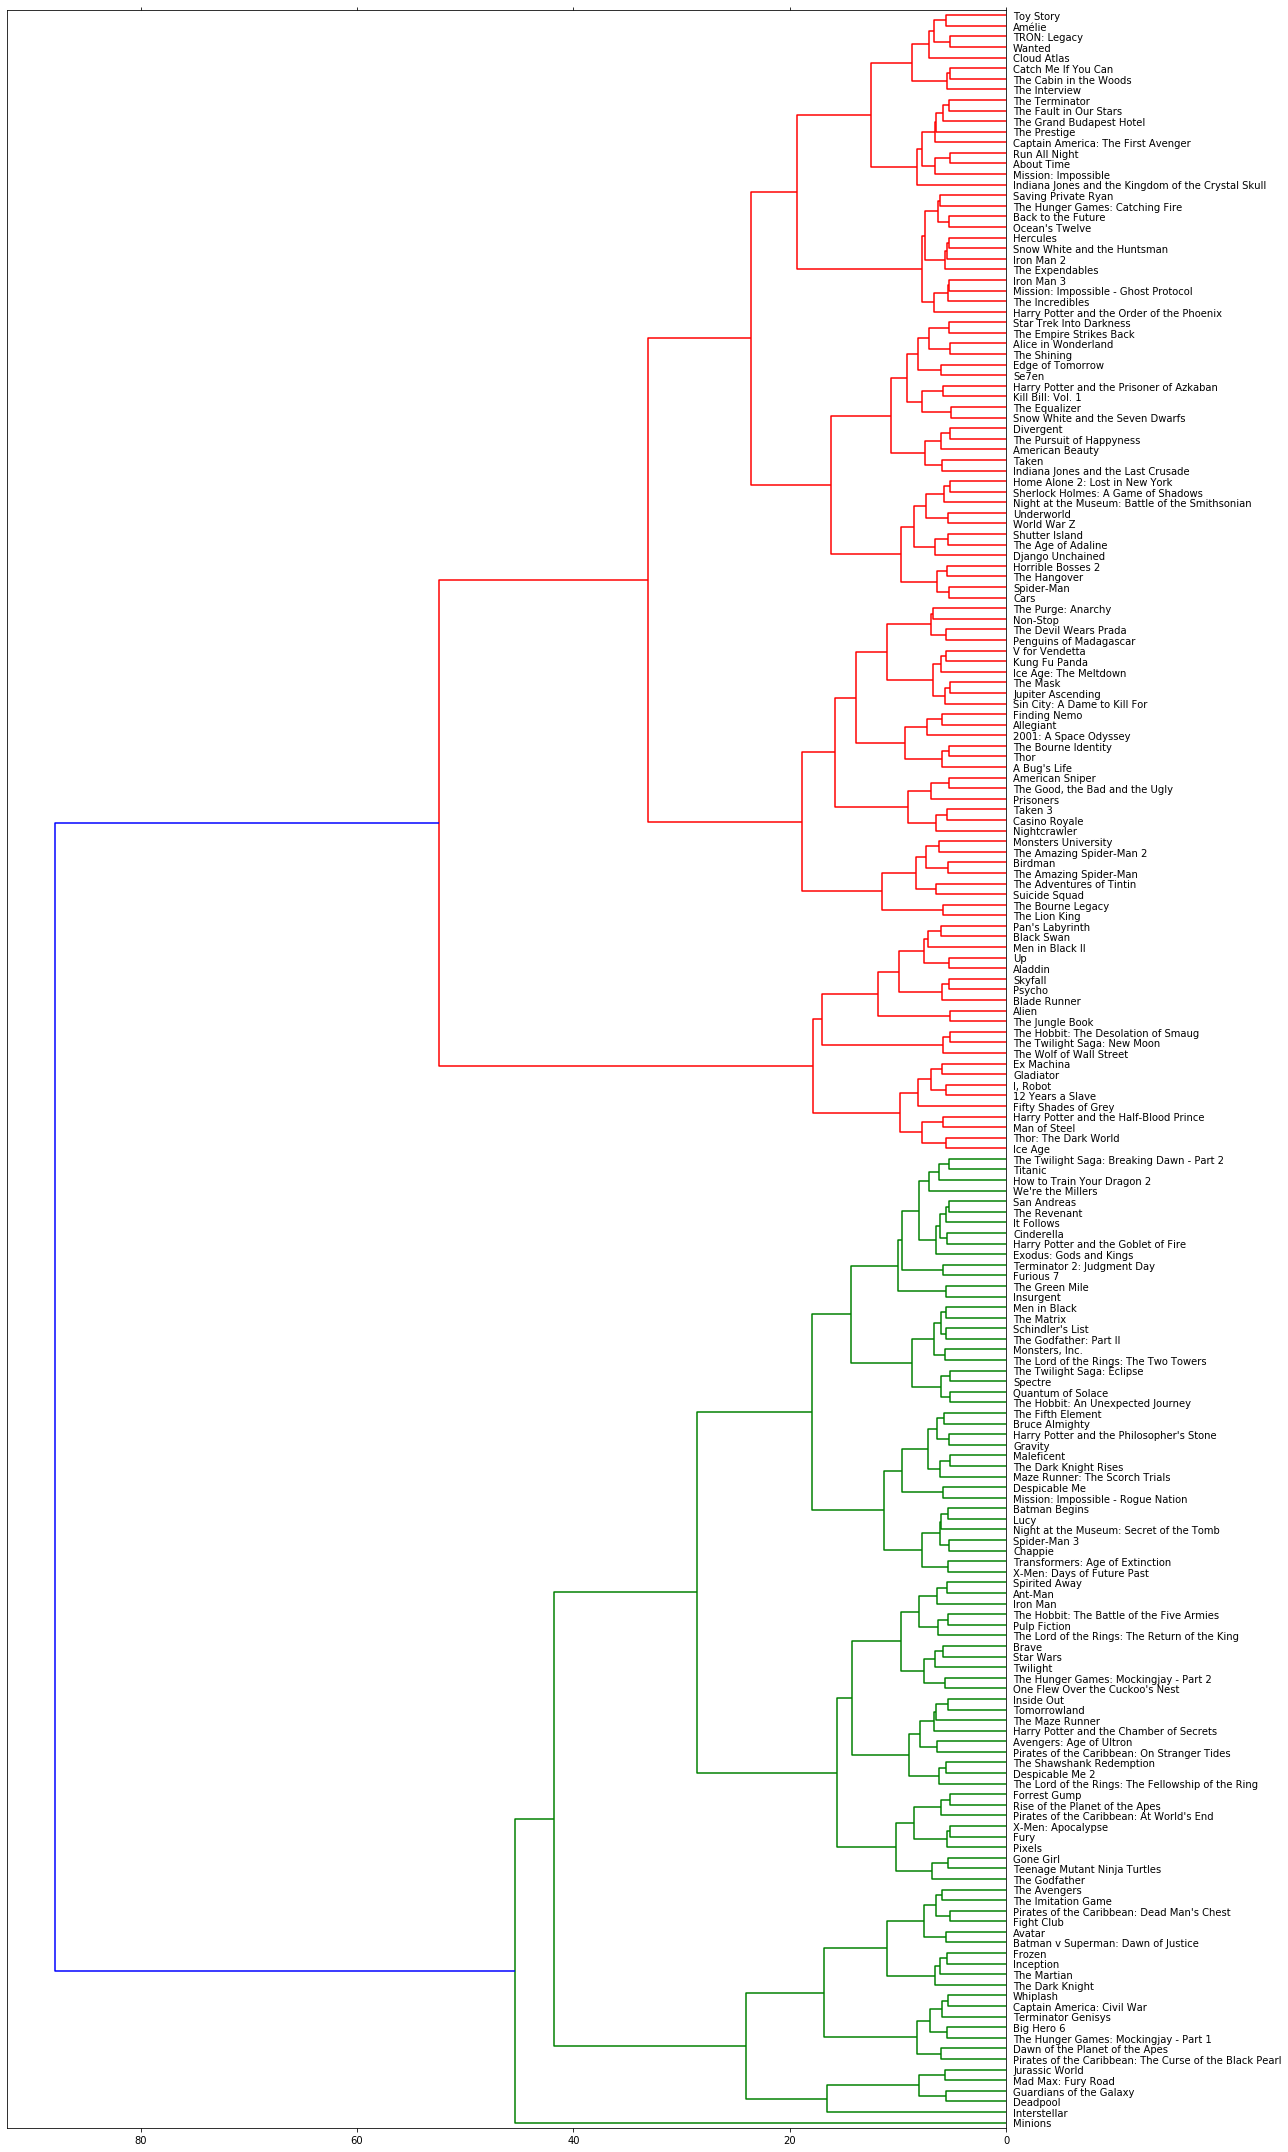

In [29]:
plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           movie_data=df,
                           figure_size=(18, 30))